In [ ]:
'''
Наше приложение это нечто совмещающее новостную ленту и мессенджер, т.е. посты можно лайкать, и 
просматривать, при этом можно обмениваться личными сообщениями.
Соберите отчет по работе всего приложения как единого целого. 
Продумайте, какие метрики необходимо отобразить в этом отчете? Как можно показать их динамику?
Приложите к отчету графики или файлы, чтобы сделать его более наглядным и информативным. 
Отчет должен быть не просто набором графиков или текста, а помогать отвечать бизнесу на вопросы о 
работе всего приложения совокупно. В отчете обязательно должны присутствовать метрики приложения 
как единого целого, или можно отобразить метрики по каждой из частей приложения — по ленте новостей 
и по мессенджеру.
'''

In [1]:
import pandahouse as ph
# Строка подключения к кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос исходной таблицы ленты новостей из БД для понимания структуры таблицы
feed = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""
# Запрос исходной таблицы мессенджера из БД для понимания структуры таблицы
messenger = """
SELECT *
FROM {db}.message_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""

In [2]:
# Наша исходная таблица ленты новостей
df_table_feed = ph.read_clickhouse(feed, connection=connection)
df_table_feed.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,12827,2004,like,2025-01-03 00:00:00,1,43,Turkey,İzmir,Android,ads,2
1,20565,1942,like,2025-01-03 00:00:00,0,23,Russia,Moscow,iOS,ads,4
2,114053,1915,view,2025-01-03 00:00:00,1,56,Russia,Kirov,Android,organic,3
3,115273,1984,view,2025-01-03 00:00:00,1,21,Russia,Moscow,iOS,organic,3
4,122707,1850,view,2025-01-03 00:00:01,1,25,Russia,Mirnyy,iOS,organic,1


In [3]:
# Наша исходная таблица мессенджера
df_table_messenger = ph.read_clickhouse(messenger, connection=connection)
df_table_messenger.head(5)

,user_id,receiver_id,time,source,exp_group,gender,age,country,city,os
0,1405,107098,2025-01-03 00:00:00,ads,0,1,27,Estonia,Tallinn,iOS
1,113395,113523,2025-01-03 00:00:00,organic,1,0,18,Russia,Novosibirsk,Android
2,1405,5791,2025-01-03 00:00:01,ads,0,1,27,Estonia,Tallinn,iOS
3,4554,110714,2025-01-03 00:00:01,ads,2,0,14,Russia,Bratsk,iOS
4,5953,110714,2025-01-03 00:00:01,ads,0,1,33,Russia,Saint Petersburg,iOS


In [ ]:
Сделаем отчет со следующими метриками
1.DAU, WAU, MAU "лента и мессенджер" "только лента"
2.Топ 10 стран по количеству пользователей "лента и мессенджер" "только лента"
3.Соотношение количества, пола, среднего возраста в разрезе "лента и мессенджер" "только лента"
4.Соотношение количества привлеченных пользователей по рекламному и органическому каналам "лента и мессенджер" 
"только лента"
5.Средний показатель вовлеченности wau/mau
6.Построим графики распределения DAU, WAU, MAU, like, view, mess/user, CTR.

In [ ]:
from datetime import date, timedelta
from telegram import Bot, Update # Для работы с ботом
from matplotlib.dates import DateFormatter, DayLocator # Форматирует метки дат на оси и то как часто их ставить
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter # Формат чисел на оси 1000 = 1К
import seaborn as sns
import io # Для перевода графиков и сообщений в бинарные данные и передача в телеграмм 
import pandas as pd
import pandahouse as ph
from airflow.decorators import dag, task # Для обьявления @dag, @task

# Создаем объект бота
my_token = 'my_token' 
bot = Bot(token=my_token)
chart_id = -938659451 
# Соединяемся с кликхаус
connection = {'host': 'https://clickhouse.lab.karpov.courses', 
             'database':'simulator_20250120', 'user':'student',
             'password':'dpo_python_2020'}

# DAU "лента и мессенджер" "только лента"
q_dau_f_fm = '''SELECT
  toDate(fa.time) as time,
  uniqExactIf(fa.user_id, fa.user_id = ma.user_id) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) ma 
ON fa.user_id = ma.user_id
GROUP BY time
ORDER BY time'''
df_dau_f_fm = ph.read_clickhouse(q_dau_f_fm, connection=connection)

# WAU "лента и мессенджер" "только лента"
q_wau_f_fm = '''SELECT
  toStartOfWeek(time) as time,
  uniqExactIf(fa.user_id, fa.user_id = ma.user_id) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) ma 
ON fa.user_id = ma.user_id
GROUP BY time
ORDER BY time'''
df_wau_f_fm = ph.read_clickhouse(q_wau_f_fm, connection=connection)

# MAU "лента и мессенджер" "только лента"
q_mau_f_fm = '''SELECT
  toStartOfMonth(time) as time,
  uniqExactIf(fa.user_id, fa.user_id = ma.user_id) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) ma 
ON fa.user_id = ma.user_id
GROUP BY time
ORDER BY time'''
df_mau_f_fm = ph.read_clickhouse(q_mau_f_fm, connection=connection)


# Гендер, пол, возраст, страна, город "лента и мессенджер" "только лента"
q_table_f_fm = '''
SELECT fa.user_id as fa_user, ma.user_id as ma_user, fa.gender, fa.age, fa.country, fa.city, fa.os, fa.source  
FROM (SELECT DISTINCT user_id, gender, age, country, city, os, source
      FROM simulator_20250120.feed_actions) as fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) as ma 
ON fa.user_id = ma.user_id'''
df_table_f_fm = ph.read_clickhouse(q_table_f_fm, connection=connection)

# WAU/DAU щбщий график
q_wau_mau = '''
SELECT t3.week as week, t3.user_id/t2.user_id as stick
FROM (SELECT t1.week, t1.user_id, toStartOfMonth(t1.week) as month
     FROM(  SELECT toStartOfWeek(time) as week, count(distinct user_id) as user_id
            FROM  simulator_20250120.feed_actions
            WHERE week < toStartOfMonth(now())
            GROUP BY week
            ORDER BY week) as t1) t3
LEFT JOIN (SELECT toStartOfMonth(time) as month, count(distinct user_id) as user_id
           FROM  simulator_20250120.feed_actions
           WHERE month < toStartOfMonth(now())
           GROUP BY month
           ORDER BY month) as t2
ON  t3.month = t2.month'''
df_wau_mau = ph.read_clickhouse(q_wau_mau, connection=connection)

# Рекламный трафик по F & FM
q_ads_org = '''
SELECT fa.time as time, uniqExactIf(fa.user_id, ma.user_id = 0 and source='ads') as f_ads,
                uniqExactIf(fa.user_id, ma.user_id = 0 and source='organic') as f_org,
                uniqExactIf(fa.user_id, fa.user_id = ma.user_id and source='ads') as fm_ads,
                uniqExactIf(fa.user_id, fa.user_id = ma.user_id and source='organic') as fm_org
FROM (SELECT DISTINCT toDate(time) as time, user_id, source 
      FROM simulator_20250120.feed_actions) as fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) as ma 
ON fa.user_id = ma.user_id
GROUP BY fa.time'''
df_ads_org  = ph.read_clickhouse(q_ads_org , connection=connection)

# Likes & View
q_like_view = '''
SELECT toDate(time) as time, 
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as ctr,
           toInt8(round((views+likes)/uniqExact(user_id), 0)) as act_user
FROM simulator_20250120.feed_actions 
GROUP BY time'''
df_like_view = ph.read_clickhouse(q_like_view , connection=connection)

# Количество сообщений на пользователя
q_mess_user = '''
SELECT toDate(time) as time, 
     count(user_id)/uniqExact(user_id) as mess_user
FROM simulator_20250120.message_actions  
GROUP BY time'''
df_mess_user = ph.read_clickhouse(q_mess_user , connection=connection)

def text():
    count_fm = df_table_f_fm[df_table_f_fm.ma_user != 0].fa_user.count()
    count_f = df_table_f_fm[df_table_f_fm.ma_user == 0].ma_user.count()
    total = count_f + count_fm
    male_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.gender == 0)].fa_user.count()
    female_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.gender == 1)].fa_user.count()
    male_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.gender == 0)].fa_user.count()
    female_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.gender == 1)].fa_user.count()
    male_per_f = male_f / count_f
    female_per_f = female_f / count_f
    male_per_fm = male_fm / count_fm
    female_per_fm = female_fm / count_fm
    age_fm = df_table_f_fm[df_table_f_fm.ma_user != 0].age.mean()
    age_f = df_table_f_fm[df_table_f_fm.ma_user == 0].age.mean()
    ads_total = df_table_f_fm[df_table_f_fm.source == 'ads'].source.count()/total
    org_total = df_table_f_fm[df_table_f_fm.source == 'organic'].source.count()/total
    org_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.source == 'organic')].source.count()/count_fm
    ads_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.source == 'ads')].source.count()/count_fm
    org_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.source == 'organic')].source.count()/count_f
    ads_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.source == 'ads')].source.count()/count_f
    stick = df_wau_mau.stick.mean()
    
    metrics = (
    f'Наша активная аудитория аудитория ({total:,}) состоит из:\n'
    f'Пользователи ленты - {count_f:,}, из них {male_per_f:.0%} мужчины, {female_per_f:.0%} женщины\n'
    f'Пользователи ленты и смс - {count_fm}, из них {male_per_fm:.0%} мужчины, {female_per_fm:.0%} женщины\n'
    f'Средний возраст пользователей \'ленты\' - {age_f:.1f}\n'
    f'Средний возраст пользователей \'лента и смс\' - {age_fm:.1f}\n'
    f'Пользователи пришедшие с рекламы - {ads_total:,.0%}\n'
    f'Пользователи пришедшие c огранического трафика - {org_total:,.0%}\n'
    f'При этом в \'ленте\': с рекламы = {ads_f:,.0%}, с органики = {org_f:,.0%}\n'    
    f'В \'ленте и смс\': с рекламы = {ads_fm:,.0%}, с органики = {org_fm:,.0%}\n'
    f'Средний показатель вовлеченности wau/mau = {stick:,.0%}')
    bot.send_message(chat_id=chat_id, text=metrics) 
        
def activ_users():
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков
    fig.suptitle('Active Users: FM vs F', fontsize=14, y=1.02)
    date_format = DateFormatter("%d-%m")
    #  График DAU
    axes[0].plot(df_dau_f_fm['time'], df_dau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
            label='FM-Users')
    axes[0].plot(df_dau_f_fm['time'], df_dau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users')
    axes[0].legend()
    axes[0].set_title('Daily Active Users FM vs F')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Users')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_formatter(date_format)

    #  График WAU
    axes[1].plot(df_wau_f_fm['time'], df_wau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
                label='FM-Users', marker='o', markersize='5')
    axes[1].plot(df_wau_f_fm['time'], df_wau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users', marker='v', markersize='5')
    axes[1].legend()
    axes[1].set_title('Weekly Active Users FM vs F')
    axes[1].set_xlabel('Date')
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].set_ylabel('Users')
    axes[1].grid(True, alpha=0.3)

    #  График MAU
    axes[2].plot(df_mau_f_fm['time'], df_mau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
                label='FM-Users',  marker='o', markersize='5')
    axes[2].plot(df_mau_f_fm['time'], df_mau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users', marker='v', markersize='5')
    axes[2].legend()
    axes[2].set_title('Monthly Active Users FM vs F')
    axes[2].set_xlabel('Date')
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].set_ylabel('Users')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'activity.png'
    bot.send_photo(chat_id=chat_id, photo=plot_object, caption="Unique users")
    plot_object.close()
    plt.close()
    
def table_country():    
    df_country = pd.DataFrame(df_table_f_fm.replace(0, pd.NA)\
    .groupby('country')\
    .agg({'fa_user' : 'nunique', 'ma_user' : 'nunique'})\
    .sort_values(by='fa_user', ascending=False).reset_index().head(10))
    # Таблица стран
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')  # Скрываем оси
     
    # Создаем таблицу
    table = ax.table(
        cellText=df_country[['fa_user', 'ma_user']].values,  
        rowLabels=df_country['country'].values,                 
        colLabels=['fa_user', 'ma_user'],                 
        cellLoc='center',
        loc='center')
    # Заголовок
    plt.title('Top 10 countries F & FM', pad=1, y=1.0, fontsize=17)                       
    # Настройка стиля
    table.auto_set_font_size(False)
    table.set_fontsize(17)
    table.scale(0.95, 2.8)  # Масштабирование (ширина, высота)
    plt.tight_layout()
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'country.png'
    bot.send_photo(chat_id=chat_id, photo=plot_object, caption="Top 10 country")
    plot_object.close()
    plt.close()    
    
def table_city():
    df_city = pd.DataFrame(df_table_f_fm.replace(0, pd.NA)\
    .groupby('city')\
    .agg({'fa_user' : 'nunique', 'ma_user' : 'nunique'})\
    .sort_values(by='fa_user', ascending=False).reset_index().head(11))
    df_city

    
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')  # Скрываем оси
    # Создаем таблицу
    table = ax.table(
        cellText=df_city[['fa_user', 'ma_user']].values,  
        rowLabels=df_city['city'].values,                 
        colLabels=['fa_user', 'ma_user'],                 
        cellLoc='center',
        loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(17)
    table.scale(0.95, 2.7)  # Масштабирование (ширина, высота)
    # Заголовок
    plt.title('Top 10 city in F & FM', pad=1,  fontsize=17)                       
    plt.tight_layout()
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'city.png'
    bot.send_photo(chat_id=chat_id, photo=plot_object, caption="Top 10 city")
    plot_object.close()
    plt.close()    

def stick():
    # WAU/MAU ADS & Organic
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков

    date_format = DateFormatter("%d-%m")
    #  График WAU/MAU
    axes[0].plot(df_wau_mau['week'], df_wau_mau['stick'], color='tab:blue', linestyle='-', linewidth=2,
                label='Stick(wau/mau)')
    axes[0].set_title('Stick(wau/mau)')
    axes[0].set_xlabel('Week')
    axes[0].set_ylabel('Stick')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_formatter(date_format)

    #  График ADS Organic лента
    axes[1].plot(df_ads_org['time'], df_ads_org['f_org'], color='tab:red', linestyle='-', linewidth=2,
                label='f_org')
    axes[1].plot(df_ads_org['time'], df_ads_org['f_ads'], color='tab:green', linestyle='--', linewidth=2,
                label='f_ads')
    axes[1].legend()
    axes[1].set_title('Feed traffic')
    axes[1].set_xlabel('Date')
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].set_ylabel('Users')
    axes[1].grid(True, alpha=0.3)

    #  График ADS Organic лента и мессенджер
    axes[2].plot(df_ads_org['time'], df_ads_org['fm_org'], color='tab:red', linestyle='-', linewidth=2,
                label='fm_org')
    axes[2].plot(df_ads_org['time'], df_ads_org['fm_ads'], color='tab:green', linestyle='--', linewidth=2,
                label='fm_ads')
    axes[2].legend()
    axes[2].set_title('Feed & Mess traffic')
    axes[2].set_xlabel('Date')
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].set_ylabel('Users')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'stick.png'
    bot.send_photo(chat_id=chat_id, photo=plot_object, caption="Traffic & stick")
    plot_object.close()
    plt.close()
    
def text_activity():
    ctr = df_like_view.ctr.mean()
    act = df_like_view.act_user.mean()
    mess = df_mess_user.mess_user.mean()
    metrics = (
    f'Средний CTR = {ctr:.1%}\n'
    f'Среднее количество активностей на пользователя = {act:.1f}\n'
    f'Среднее количество сообщений на пользователя = {mess:.1f}\n'
    f'Динамика метрик на графиках ниже'
    )
    bot.send_message(chat_id=chat_id, text=metrics)    
    
def activity():
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков
    fig.suptitle('Active in FM vs F', fontsize=20, y=1.0)
    date_format = DateFormatter("%d-%m")
    formatter = EngFormatter(unit='') 
    #  График likes & view
    axes[0, 0].plot(df_like_view['time'], df_like_view['views'], color='tab:blue', linestyle='--', linewidth=2,
                label='Views')
    axes[0, 0].plot(df_like_view['time'], df_like_view['likes'], color='tab:red', linestyle='-', linewidth=2,
                label='Likes')
    axes[0, 0].legend()
    axes[0, 0].set_title('Likes & Views')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Users')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_formatter(date_format)
    axes[0, 0].yaxis.set_major_formatter(formatter)
    #  График CTR
    axes[0, 1].plot(df_like_view['time'], df_like_view['ctr'], color='tab:green', linestyle='--', linewidth=2,
                label='CTR')
    axes[0, 1].legend()
    axes[0, 1].set_title('CTR')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('CTR')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_formatter(date_format)
    #  График Action per user
    axes[1, 0].plot(df_like_view['time'], df_like_view['act_user'], color='tab:gray', linestyle='-', linewidth=2,
                label='Action')
    axes[1, 0].legend()
    axes[1, 0].set_title('Action per user')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Action')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_formatter(date_format)
    #  График Mess per user
    axes[1, 1].plot(df_mess_user['time'], df_mess_user['mess_user'], color='tab:olive', linestyle='-', linewidth=2,
                label='Mess')
    axes[1, 1].legend()
    axes[1, 1].set_title('Mess per user')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Messange')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'city.png'
    bot.send_photo(chat_id=chat_id, photo=plot_object, caption="Activity dynamics")
    plot_object.close()
    plt.close()    
# Аргументы DAG
default_args = {
    'owner': 'A.Dotsenko',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2025, 3, 1)}
schedule_interval = '0 8 * * *'
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def add_report_dotsenko():
    
    @task() 
    def send_text():
        text()
        activ_users()
        table_country()
        table_city()
        stick()
        text_activity()
        activity()
    send_text()    

add_report_dotsenko = add_report_dotsenko()     

In [2]:
'''
Чтоб  проверить что все функции работают и на выходе мы получаем то, что нужно, посмотрим отдельно работу
каждой функции и то что она выводит'''

In [1]:
from datetime import date, timedelta
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import seaborn as sns
import io
import pandas as pd
import pandahouse as ph

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses', 
             'database':'simulator_20250120', 'user':'student',
             'password':'dpo_python_2020'}

In [5]:
# DAU, WAU, MAU - все метрики считаются по одному запросу с разным временным отрезком.
# Каждый запрос имеет подзапрос пользователей из месенджера сгруппированных по временному
# отрезку. Во внешнем запросе мы получаем пользователей по тому же временному отрезку но с ленты.
# Эти запросы джойнятся по левому джоину, т.к. все пользователи пользуются лентой, и лишь некоторый еще мессенджером.
# После соединения мы можем применять условия для подсчета пользователей только из ленты или только из мессенджера.
# DAU "лента и мессенджер" "только лента"
q_dau_f_fm = '''SELECT
  toDate(fa.time) as time,
  uniqExactIf(fa.user_id, ma.user_id != 0) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT toDate(time) as time, user_id
            FROM simulator_20250120.message_actions
            GROUP BY time, user_id) ma 
ON fa.user_id = ma.user_id and time = ma.time
GROUP BY time
ORDER BY time'''
df_dau_f_fm = ph.read_clickhouse(q_dau_f_fm, connection=connection)

# WAU "лента и мессенджер" "только лента"
q_wau_f_fm = '''SELECT
  toStartOfWeek(fa.time) as time,
  uniqExactIf(fa.user_id, ma.user_id != 0) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT toStartOfWeek(time) as time, user_id
            FROM simulator_20250120.message_actions
            GROUP BY time, user_id) ma 
ON fa.user_id = ma.user_id and time = ma.time
GROUP BY time
ORDER BY time'''
df_wau_f_fm = ph.read_clickhouse(q_wau_f_fm, connection=connection)

# MAU "лента и мессенджер" "только лента"
q_mau_f_fm = '''SELECT
  toStartOfMonth(fa.time) as time,
  uniqExactIf(fa.user_id, ma.user_id != 0) as user_fm,
  uniqExactIf(fa.user_id, ma.user_id = 0) as user_f
FROM
  simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT toStartOfMonth(time) as time, user_id
            FROM simulator_20250120.message_actions
            GROUP BY time, user_id) ma 
ON fa.user_id = ma.user_id and time = ma.time
GROUP BY time
ORDER BY time'''
df_mau_f_fm = ph.read_clickhouse(q_mau_f_fm, connection=connection)


# Гендер, пол, возраст, страна, город "лента и мессенджер" "только лента"
# В данном запросе мы делаем два подзапроса к ленте и мессенджеру соответственно. Из ленты мы берем все данные
# которые нам будут нужны по каждому уникальному пользователю, а из мессенджера мы берем только id пользователей.
# После соединяем левым джоином, таким образом получая возможность по условию наличия пользователя в мессенджере или
# отсутствию считать нужные нам метрики (количество, пол, возраст) по каждой группе отдельно.
q_table_f_fm = '''
SELECT fa.user_id as fa_user, ma.user_id as ma_user, 
       fa.gender, fa.age, fa.country, 
       fa.city, fa.os, fa.source  
FROM (SELECT DISTINCT user_id, gender, age, country, city, os, source
      FROM simulator_20250120.feed_actions) as fa
LEFT JOIN ( SELECT DISTINCT user_id
            FROM simulator_20250120.message_actions) as ma 
ON fa.user_id = ma.user_id'''
df_table_f_fm = ph.read_clickhouse(q_table_f_fm, connection=connection)

# WAU/MAU Делаем два подзапроса, в одном мы достаем количество пользователей по неделям + создаем новый столбец
# с приведением недели к началу месяца. В другом мы считаем ползователей просто по месяцам. Везде ограничиваем
# даты началом месяца (week < toStartOfMonth(now()))- чтобы были полные недели и полные месяца. Внешний запрос 
# соединяет два подзапроса по месяцу, и считает отношение недели в соответ-м месяце к месяцу.
q_wau_mau = '''
SELECT t3.week as week, t3.user_id/t2.user_id as stick
FROM (SELECT t1.week, t1.user_id, toStartOfMonth(t1.week) as month
     FROM(  SELECT toStartOfWeek(time) as week, count(distinct user_id) as user_id
            FROM  simulator_20250120.feed_actions
            WHERE week < toStartOfMonth(now())
            GROUP BY week
            ORDER BY week) as t1) t3
LEFT JOIN (SELECT toStartOfMonth(time) as month, count(distinct user_id) as user_id
           FROM  simulator_20250120.feed_actions
           WHERE month < toStartOfMonth(now())
           GROUP BY month
           ORDER BY month) as t2
ON  t3.month = t2.month'''
df_wau_mau = ph.read_clickhouse(q_wau_mau, connection=connection)

# Рекламный трафик по F & FM
# В подзапросе мы получаем уникальных пользователей мессенджера сгруппированных по датам
# (одна дата - один пользователь).А далее соединяем левым джоином с пользователями ленты по
# дате и юзер id, и считаем количество трафика по условию наличия пользователя в мессенджере или 
# отсутствию.

q_ads_org = '''
SELECT toDate(fa.time) as time, uniqExactIf(fa.user_id, ma.user_id = 0 and source='ads') as f_ads,
                uniqExactIf(fa.user_id, ma.user_id = 0 and source='organic') as f_org,
                uniqExactIf(fa.user_id, ma.user_id != 0 and source='ads') as fm_ads,
                uniqExactIf(fa.user_id, ma.user_id != 0 and source='organic') as fm_org
FROM simulator_20250120.feed_actions fa
LEFT JOIN ( SELECT toDate(time) as time, user_id
            FROM simulator_20250120.message_actions
            GROUP BY time, user_id) as ma 
ON fa.user_id = ma.user_id and time = ma.time
GROUP BY time'''
df_ads_org  = ph.read_clickhouse(q_ads_org , connection=connection)

# Likes & View, ctr из ленты, и общее количество активностей views+likes на пользователя
q_like_view = '''
SELECT toDate(time) as time, 
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as ctr,
           toInt8(round((views+likes)/uniqExact(user_id), 0)) as act_user
FROM simulator_20250120.feed_actions 
GROUP BY time'''
df_like_view = ph.read_clickhouse(q_like_view , connection=connection)

# Считаем количество сообщений на пользователя по дням
q_mess_user = '''
SELECT toDate(time) as time, 
     count(user_id)/uniqExact(user_id) as mess_user
FROM simulator_20250120.message_actions  
GROUP BY time'''
df_mess_user = ph.read_clickhouse(q_mess_user , connection=connection)



In [8]:
# Функция для письменного отчета по количетву и соотношению пользователей, пола и возраста в ленте и мессенджере
def text(df_table_f_fm, df_wau_mau):
    count_fm = df_table_f_fm[df_table_f_fm.ma_user != 0].fa_user.count() # Пользователи ленты и смс
    count_f = df_table_f_fm[df_table_f_fm.ma_user == 0].ma_user.count() # Пользователи ленты
    total = count_f + count_fm  # Активная аудитория аудитория
    male_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.gender == 0)].fa_user.count() # Мужчины
    female_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.gender == 1)].fa_user.count()# Женщины
    male_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.gender == 0)].fa_user.count()
    female_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.gender == 1)].fa_user.count()
    male_per_f = male_f / count_f # % Мужчины лента
    female_per_f = female_f / count_f # % Женщины лента
    male_per_fm = male_fm / count_fm # % Мужчины мессенджер
    female_per_fm = female_fm / count_fm # % Женщины мессенджер
    age_fm = df_table_f_fm[df_table_f_fm.ma_user != 0].age.mean() # Средний возраст лента
    age_f = df_table_f_fm[df_table_f_fm.ma_user == 0].age.mean() # Средний возраст мессенджер
    ads_total = df_table_f_fm[df_table_f_fm.source == 'ads'].source.count()/total # % ads
    org_total = df_table_f_fm[df_table_f_fm.source == 'organic'].source.count()/total # % org
    org_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.source == 'organic')].source.count()/count_fm
    ads_fm = df_table_f_fm[(df_table_f_fm.ma_user != 0) & (df_table_f_fm.source == 'ads')].source.count()/count_fm
    org_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.source == 'organic')].source.count()/count_f
    ads_f = df_table_f_fm[(df_table_f_fm.ma_user == 0) & (df_table_f_fm.source == 'ads')].source.count()/count_f
    stick = df_wau_mau.stick.mean() # Среднее wau/mau
    
    metrics = (
    f'Наша активная аудитория аудитория ({total:,}) состоит из:\n'
    f'Пользователи ленты - {count_f:,}, из них {male_per_f:.0%} мужчины, {female_per_f:.0%} женщины\n'
    f'Пользователи ленты и смс - {count_fm}, из них {male_per_fm:.0%} мужчины, {female_per_fm:.0%} женщины\n'
    f'Средний возраст пользователей \'ленты\' - {age_f:.1f}\n'
    f'Средний возраст пользователей \'лента и смс\' - {age_fm:.1f}\n'
    f'Пользователи пришедшие с рекламы - {ads_total:,.0%}\n'
    f'Пользователи пришедшие c огранического трафика - {org_total:,.0%}\n'
    f'При этом в \'ленте\': с рекламы = {ads_f:,.0%}, с органики = {org_f:,.0%}\n'    
    f'В \'ленте и смс\': с рекламы = {ads_fm:,.0%}, с органики = {org_fm:,.0%}\n'
    f'Средний показатель вовлеченности wau/mau = {stick:,.0%}')
    return print(metrics)
text(df_table_f_fm, df_wau_mau)

Наша активная аудитория аудитория (159,529) состоит из:
Пользователи ленты - 108,819, из них 45% мужчины, 55% женщины
Пользователи ленты и смс - 50710, из них 45% мужчины, 55% женщины
Средний возраст пользователей 'ленты' - 27.2
Средний возраст пользователей 'лента и смс' - 27.2
Пользователи пришедшие с рекламы - 61%
Пользователи пришедшие c огранического трафика - 39%
При этом в 'ленте': с рекламы = 67%, с органики = 33%
В 'ленте и смс': с рекламы = 49%, с органики = 51%
Средний показатель вовлеченности wau/mau = 54%


In [9]:
# Функция которая строит графики DAU, MAU, WAU
def activ_users(df_dau_f_fm, df_wau_f_fm, df_mau_f_fm):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков
    fig.suptitle('Active Users: FM vs F', fontsize=14, y=1.02)
    date_format = DateFormatter("%d-%m")
    #  График DAU
    axes[0].plot(df_dau_f_fm['time'], df_dau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
            label='FM-Users')
    axes[0].plot(df_dau_f_fm['time'], df_dau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users')
    axes[0].legend()
    axes[0].set_title('Daily Active Users FM vs F')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Users')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_formatter(date_format)

    #  График WAU
    axes[1].plot(df_wau_f_fm['time'], df_wau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
                label='FM-Users', marker='o', markersize='5')
    axes[1].plot(df_wau_f_fm['time'], df_wau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users', marker='v', markersize='5')
    axes[1].legend()
    axes[1].set_title('Weekly Active Users FM vs F')
    axes[1].set_xlabel('Date')
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].set_ylabel('Users')
    axes[1].grid(True, alpha=0.3)

    #  MAU
    axes[2].plot(df_mau_f_fm['time'], df_mau_f_fm['user_fm'], color='tab:blue', linestyle='--', linewidth=2,
                label='FM-Users',  marker='o', markersize='5')
    axes[2].plot(df_mau_f_fm['time'], df_mau_f_fm['user_f'], color='tab:red', linestyle='-', linewidth=2,
                label='F-Users', marker='v', markersize='5')
    axes[2].legend()
    axes[2].set_title('Monthly Active Users FM vs F')
    axes[2].set_xlabel('Date')
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].set_ylabel('Users')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    


/tmp/ipykernel_52/734017907.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Улучшенный стиль графиков


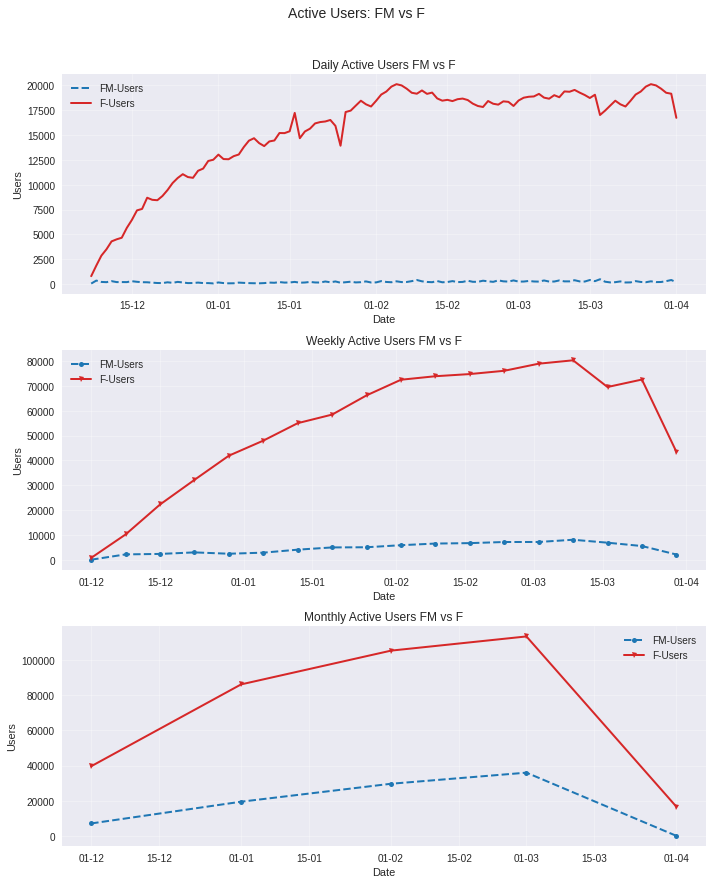

In [10]:
activ_users(df_dau_f_fm, df_wau_f_fm, df_mau_f_fm)

In [9]:
# Функция которая строит таблицу топ 10 стран по количеству пользователей
def table_country(df_table_f_fm):  
    # Создаем датафрейм с группировкой по странам и считаем количество пользователей
    df_country = pd.DataFrame(df_table_f_fm.replace(0, pd.NA)\ # чтоб при группировке не учитывались 0, замена NA
    .groupby('country')\
    .agg({'fa_user' : 'nunique', 'ma_user' : 'nunique'})\
    .sort_values(by='fa_user', ascending=False).reset_index().head(10))
    # Создаем фигуру
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')  # Скрываем оси чтоб не были видны
     
    # Создаем таблицу
    table = ax.table(
        cellText=df_country[['fa_user', 'ma_user']].values,  # Данные для ячеек
        rowLabels=df_country['country'].values,              # Подписи строк (названия стран)                
        colLabels=['fa_user', 'ma_user'],                    # Названия колонок таблицы
        cellLoc='center',                                    # Выравнивание текста по центру ячеек
        loc='center')                                        # Центрирование таблицы на графике
    # Заголовок
    plt.title('Top 10 countries F & FM', pad=1, y=1.0, fontsize=17)                       
    # Настройка стиля
    table.auto_set_font_size(False)  # Отключение авторазмера шрифта
    table.set_fontsize(17)   # Размер шрифта в таблице
    table.scale(0.95, 2.8)  # Масштабирование (ширина, высота) ячеек таблицы
    plt.tight_layout()      # Автоматически настраивает отступы, чтобы таблица не обрезалась

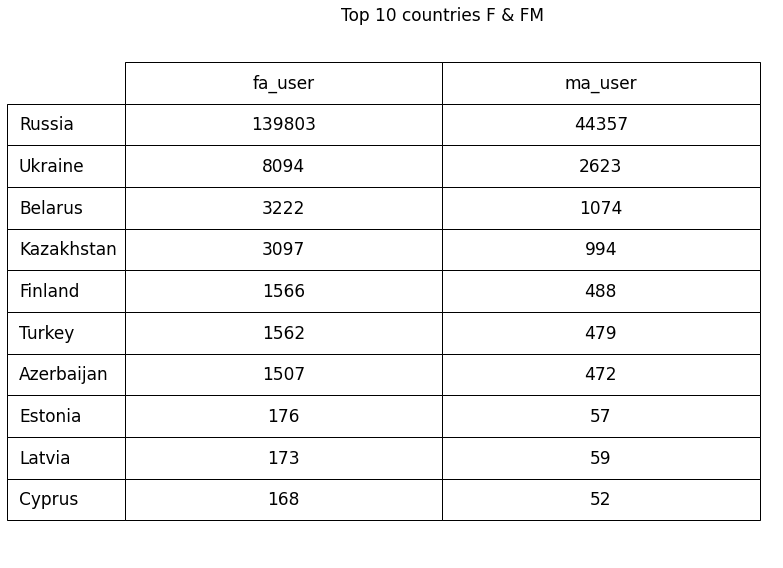

In [10]:
table_country(df_table_f_fm)

In [11]:
# Функция которая строит графики количество пользователей по трафику в ленте и мессенджере, и график WAU/MAU
def stick(df_wau_mau, df_ads_org):
   # WAU/MAU ADS & Organic
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков

    date_format = DateFormatter("%d-%m") # Формат даты на оси
    #  График WAU/MAU
    axes[0].plot(df_wau_mau['week'], df_wau_mau['stick'], color='tab:blue', linestyle='-', linewidth=2,
                label='Stick(wau/mau)')
    axes[0].set_title('Stick(wau/mau)')
    axes[0].set_xlabel('Week')
    axes[0].set_ylabel('Stick')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_formatter(date_format)

    #  График ADS Organic лента
    axes[1].plot(df_ads_org['time'], df_ads_org['f_org'], color='tab:red', linestyle='-', linewidth=2,
                label='f_org')
    axes[1].plot(df_ads_org['time'], df_ads_org['f_ads'], color='tab:green', linestyle='--', linewidth=2,
                label='f_ads')
    axes[1].legend()
    axes[1].set_title('Feed traffic')
    axes[1].set_xlabel('Date')
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].set_ylabel('Users')
    axes[1].grid(True, alpha=0.3)

    #  График ADS Organic лента и мессенджер
    axes[2].plot(df_ads_org['time'], df_ads_org['fm_org'], color='tab:red', linestyle='-', linewidth=2,
                label='fm_org')
    axes[2].plot(df_ads_org['time'], df_ads_org['fm_ads'], color='tab:green', linestyle='--', linewidth=2,
                label='fm_ads')
    axes[2].legend()
    axes[2].set_title('Feed & Mess traffic')
    axes[2].set_xlabel('Date')
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].set_ylabel('Users')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    

/tmp/ipykernel_49/2817519761.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Улучшенный стиль графиков


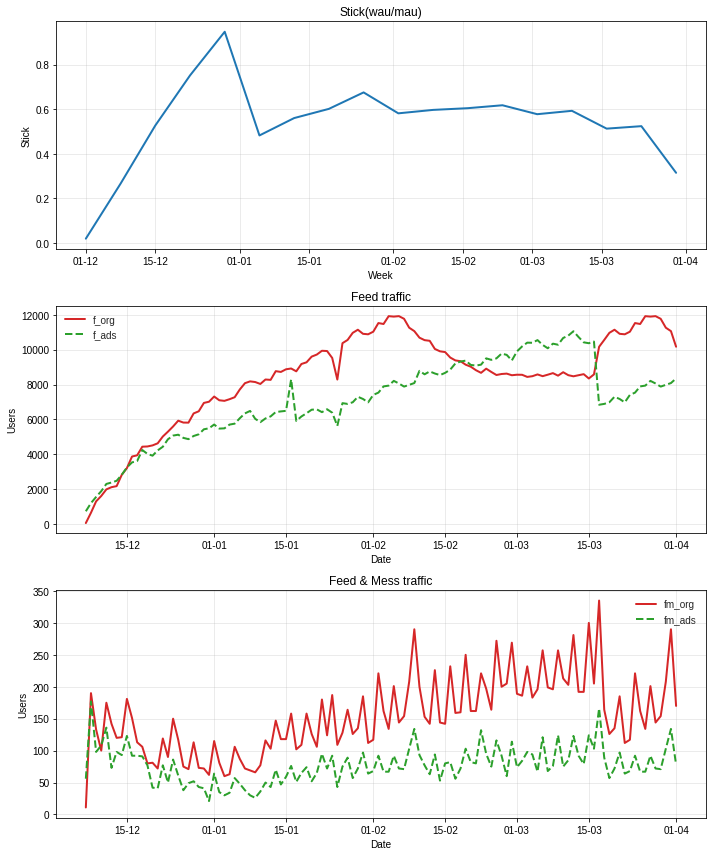

In [12]:
stick(df_wau_mau, df_ads_org)

In [16]:
# Функция которая формирует сообщение со значениями метрик 
def text_activity(df_like_view, df_mess_user):
    ctr = df_like_view.ctr.mean()
    act = df_like_view.act_user.mean()
    mess = df_mess_user.mess_user.mean()
    metrics = (
    f'Средний CTR = {ctr:.1%}\n'
    f'Среднее количество активностей на пользователя = {act:.1f}\n'
    f'Среднее количество сообщений на пользователя = {mess:.1f}\n'
    f'Динамика метрик на графиках ниже')
    return print(metrics)
text_activity(df_like_view, df_mess_user)


Средний CTR = 21.0%
Среднее количество активностей на пользователя = 43.5
Среднее количество сообщений на пользователя = 10.0
Динамика метрик на графиках ниже


In [17]:
# Функция для построения графиков like_view, CTR, Mess per user
def activity(df_like_view, df_mess_user):
    # Создаем фигуру
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков
    fig.suptitle('Active in FM vs F', fontsize=20, y=1.0)
    date_format = DateFormatter("%d-%m") # Формат дат на оси
    formatter = EngFormatter(unit='') # Автоматически подбирает префикс (К, M) и удаляет единицы измерения
    #  График likes & view
    axes[0, 0].plot(df_like_view['time'], df_like_view['views'], color='tab:blue', linestyle='--', linewidth=2,
                label='Views')
    axes[0, 0].plot(df_like_view['time'], df_like_view['likes'], color='tab:red', linestyle='-', linewidth=2,
                label='Likes')
    axes[0, 0].legend()
    axes[0, 0].set_title('Likes & Views')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Users')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_formatter(date_format)
    axes[0, 0].yaxis.set_major_formatter(formatter)

    #  График CTR
    axes[0, 1].plot(df_like_view['time'], df_like_view['ctr'], color='tab:green', linestyle='--', linewidth=2,
                label='CTR')
    axes[0, 1].legend()
    axes[0, 1].set_title('CTR')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('CTR')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_formatter(date_format)

    #  График Action per user
    axes[1, 0].plot(df_like_view['time'], df_like_view['act_user'], color='tab:gray', linestyle='-', linewidth=2,
                label='Action')
    axes[1, 0].legend()
    axes[1, 0].set_title('Action per user')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Action')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_formatter(date_format)

    #  График Mess per user
    axes[1, 1].plot(df_mess_user['time'], df_mess_user['mess_user'], color='tab:olive', linestyle='-', linewidth=2,
                label='Mess')
    axes[1, 1].legend()
    axes[1, 1].set_title('Mess per user')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Messange')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    

/tmp/ipykernel_49/1428027095.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Улучшенный стиль графиков


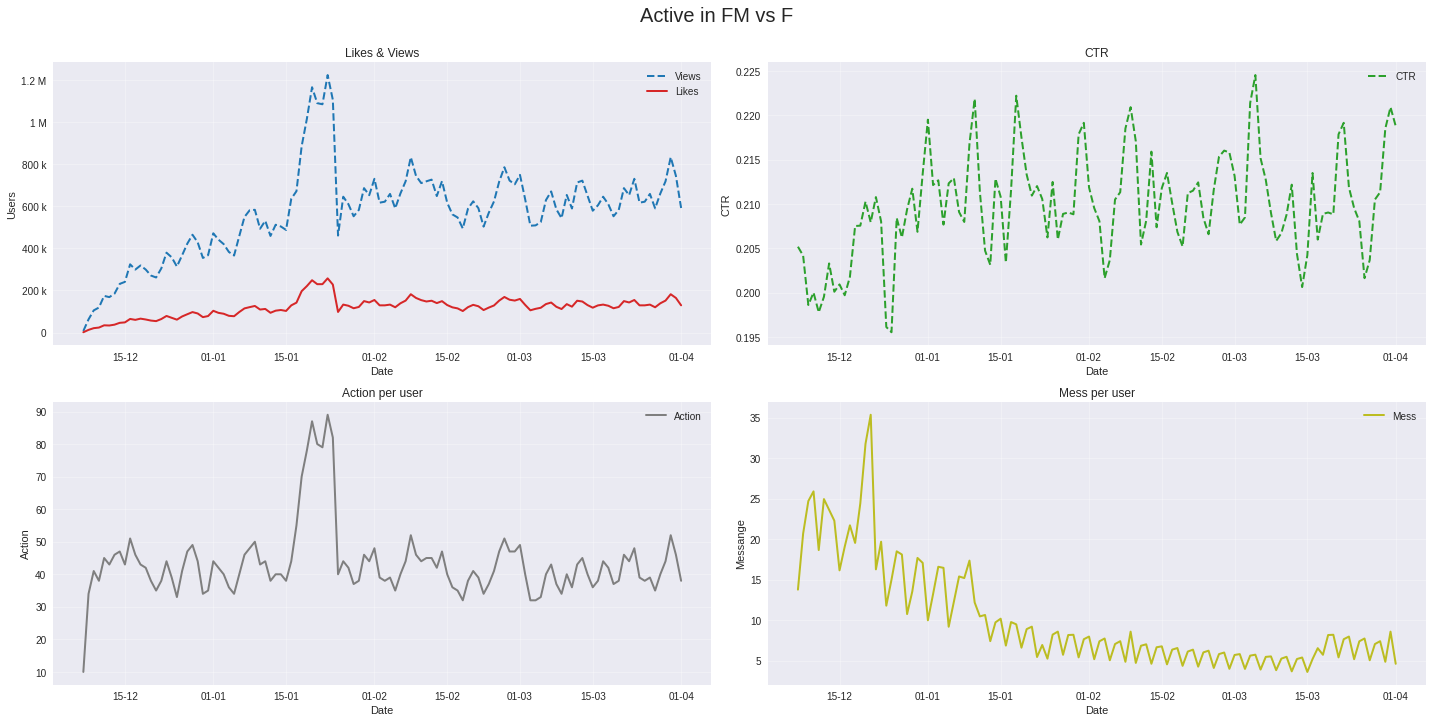

In [18]:
activity(df_like_view, df_mess_user)